# Texture

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

## Filter banks

In this section, we build a simple filter bank of four Gabor filters, and use it as a basis for creating a texture descriptor. 

First, we read two images of different textures that are used as examples.

In [3]:
tex1 = cv2.imread('images/D11.png')
tex1 = cv2.cvtColor(tex1, cv2.COLOR_BGR2GRAY)
tex1 = tex1[0:200,0:200]

In [4]:
tex2 = cv2.imread('images/D16.png')
tex2 = cv2.cvtColor(tex2, cv2.COLOR_BGR2GRAY)
tex2 = tex2[0:200,0:200]

(-0.5, 199.5, 199.5, -0.5)

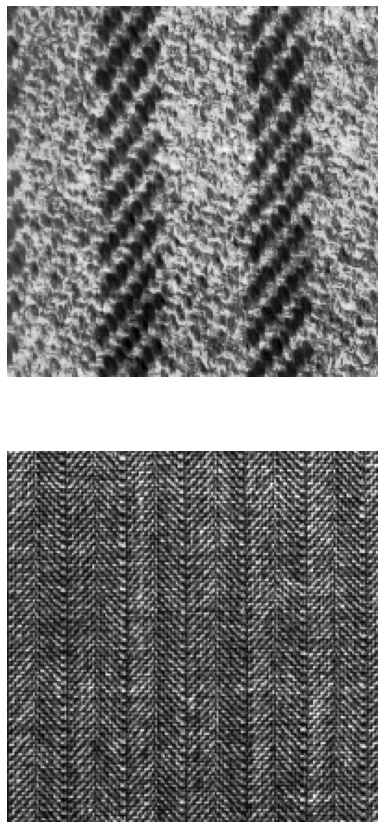

In [5]:
plt.figure(figsize=(10,15))
plt.subplot(211)
plt.imshow(tex1,cmap='gray')
plt.axis('off')
plt.subplot(212)
plt.imshow(tex2,cmap='gray')
plt.axis('off')

Next, we define the filters and visualize them.

In [6]:
kern1 = cv2.getGaborKernel((11, 11),3,np.pi/4,11,1)
kern2 = cv2.getGaborKernel((11, 11),3,-np.pi/4,11,1)
kern3 = cv2.getGaborKernel((11, 11),2,np.pi/4,5,1)
kern4 = cv2.getGaborKernel((11, 11),2,-np.pi/4,5,1)

(-0.5, 10.5, 10.5, -0.5)

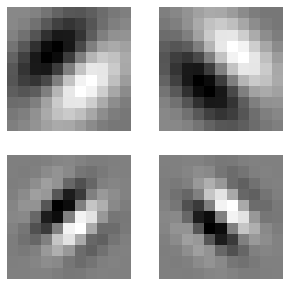

In [7]:
plt.figure(figsize=(5,5))
plt.subplot(221)
plt.imshow(kern1, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.imshow(kern2, cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(kern3, cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.imshow(kern4, cmap='gray')
plt.axis('off')

We apply these filters to the input images. As a result, we get four output channels to both images that are visualized below.

In [8]:
out1_1 = cv2.filter2D(tex1.astype(np.float32)/255, -1, kern1)
out2_1 = cv2.filter2D(tex1.astype(np.float32)/255, -1, kern2)
out3_1 = cv2.filter2D(tex1.astype(np.float32)/255, -1, kern3)
out4_1 = cv2.filter2D(tex1.astype(np.float32)/255, -1, kern4)

In [9]:
out1_2 = cv2.filter2D(tex2.astype(np.float32)/255, -1, kern1)
out2_2 = cv2.filter2D(tex2.astype(np.float32)/255, -1, kern2)
out3_2 = cv2.filter2D(tex2.astype(np.float32)/255, -1, kern3)
out4_2 = cv2.filter2D(tex2.astype(np.float32)/255, -1, kern4)

(-0.5, 199.5, 199.5, -0.5)

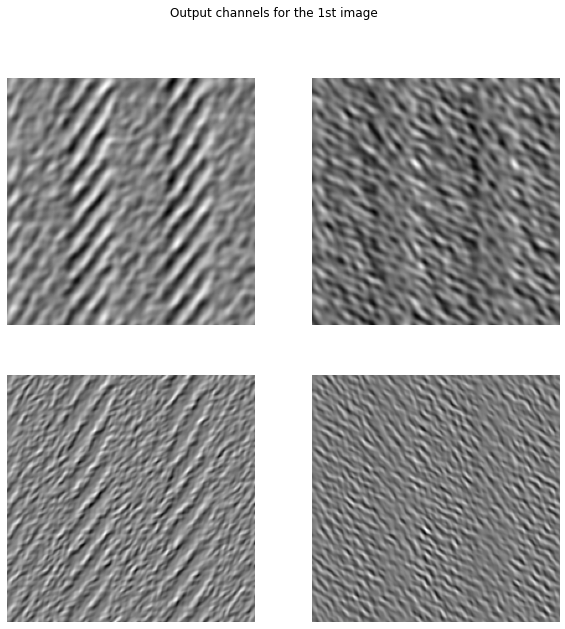

In [10]:
plt.figure(figsize=(10,10))
plt.suptitle('Output channels for the 1st image')
plt.subplot(221)
plt.imshow(out1_1, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.imshow(out2_1, cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(out3_1, cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.imshow(out4_1, cmap='gray')
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

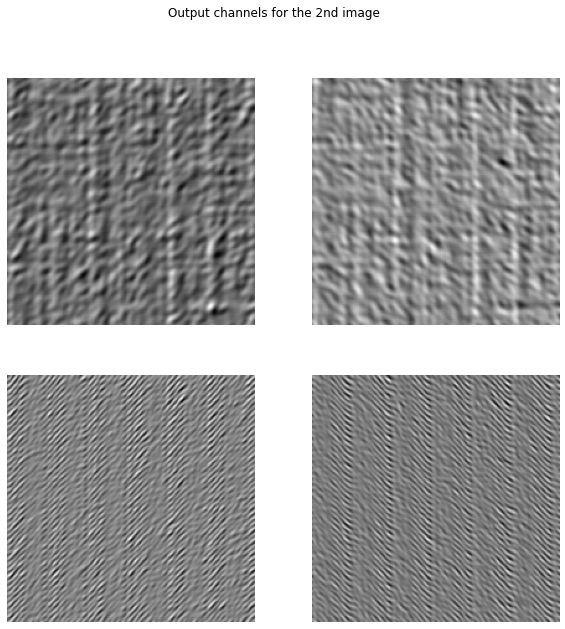

In [11]:
plt.figure(figsize=(10,10))
plt.suptitle('Output channels for the 2nd image')
plt.subplot(221)
plt.imshow(out1_2, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.imshow(out2_2, cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(out3_2, cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.imshow(out4_2, cmap='gray')
plt.axis('off')

In order to construct the texture descriptor, we define a function that quantizes each value of the output channels to one bit based on its sign so that a negative value corresponds to 0 and a positive value to 1. After quantization the values are binary coded, and every pixel is represented with a four-bit label in a range $[0, 15]$.

The corresponding texture maps (labeled images) are shown below.

In [12]:
def get_label(f1, f2, f3, f4):
    return (f1>0).astype(np.uint8)+2*(f2>0).astype(np.uint8)+4*(f3>0).astype(np.uint8)+8*(f4>0).astype(np.uint8)

In [13]:
label1 = get_label(out1_1, out2_1, out3_1, out4_1)
label2 = get_label(out1_2, out2_2, out3_2, out4_2)

(-0.5, 199.5, 199.5, -0.5)

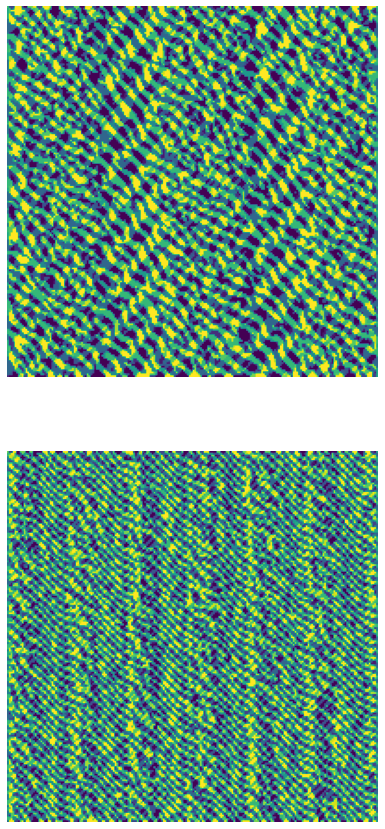

In [14]:
plt.figure(figsize=(10,15))
plt.subplot(211)
plt.imshow(label1)
plt.axis('off')
plt.subplot(212)
plt.imshow(label2)
plt.axis('off')

Finally, we construct the texture descriptors simply from the histograms of the texture maps.

The descriptors shown below clearly demonstrate the different distributions of the textons in the two input images. The descriptors provide a feature vector that can be used to classify the textures.

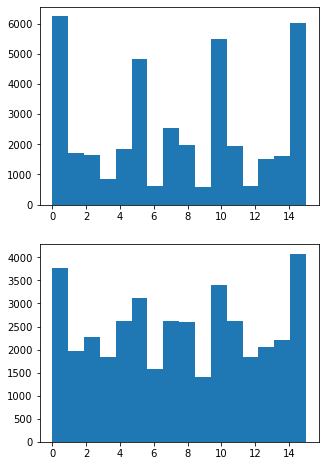

In [15]:
plt.figure(figsize=(5,8))
plt.subplot(211)
h=plt.hist(label1.ravel(),16)
plt.subplot(212)
h=plt.hist(label2.ravel(),16)

## Local binary pattern (LBP)

The following function implements the simplest form of the local binary pattern descriptor where the center pixel is compared to the eight neighboring pixels, and the sign of the difference gives the bit value in the same way as in the previous method. This leads to eight bits per pixel that are binary coded and represented as an integer between 0 and 255.

In [16]:
def LBP(img):
    m,n = img.shape
    out = np.zeros((m-2, n-2, 8), dtype=np.uint8)
    disp = ((-1, -1),(-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))
    center = img[1:-1, 1:-1]
    for i, d in enumerate(disp):
        out[:,:,i] = img[d[0] + 1 : d[0] + m - 1, d[1] + 1 : d[1] + m - 1] > center
        out[:,:,i] = 2**i * out[:,:,i]
    out = np.sum(out, axis = 2)
    hist, _ = np.histogram(out, 256)
    return hist, out

We use this function to calculate the LPB descriptors and texture maps for the two input images. The results are shown below.

In [17]:
h1, lab1 = LBP(tex1)
h2, lab2 = LBP(tex2)

(-0.5, 197.5, 197.5, -0.5)

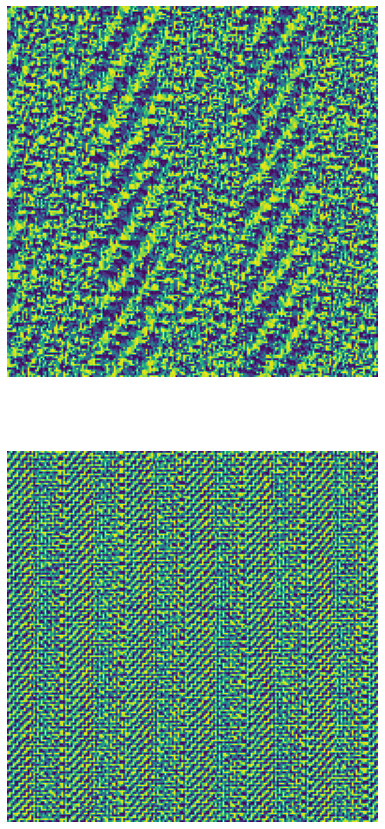

In [18]:
plt.figure(figsize=(10,15))
plt.subplot(211)
plt.imshow(lab1)
plt.axis('off')
plt.subplot(212)
plt.imshow(lab2)
plt.axis('off')

<BarContainer object of 256 artists>

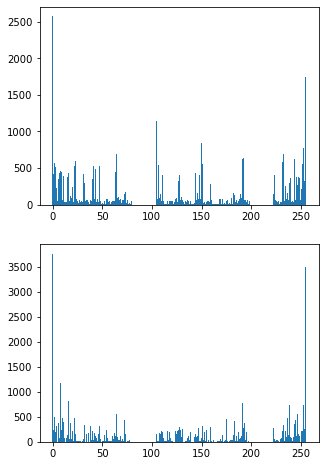

In [19]:
plt.figure(figsize=(5,8))
plt.subplot(211)
plt.bar(np.arange(256),h1)
plt.subplot(212)
plt.bar(np.arange(256),h2)

Again, we can notice considerable difference between the distributions of the textons in the two images.